# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [10]:
df = pd.read_csv('../Data/merged_dataset.csv')

df.set_index('Date',inplace=True)

print(df.head())

            carbon_price  oil_price  gas_price
Date                                          
2017-01-02          6.12        NaN       3.71
2017-01-03          5.43      52.36       3.41
2017-01-04          5.72      53.26       3.42
2017-01-05          5.29      53.77       3.42
2017-01-06          5.50      53.98       3.38


# EDA

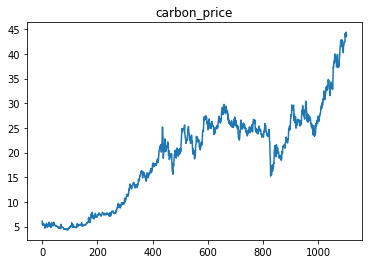

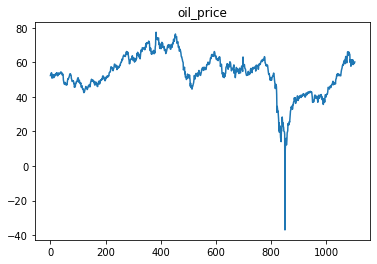

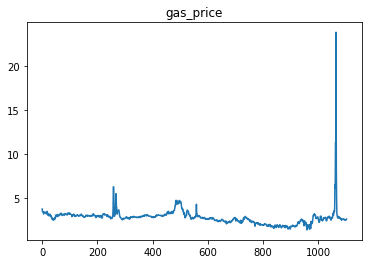

In [54]:
for col in df.columns:
    plt.plot(np.asarray(df[col]))
    plt.title("{}".format(col))
    #plt.plot(df[col])
    plt.show()

# Data preprocessing

## Handle missing values

In [12]:
df = df.fillna(method='bfill')

## Stationarity checks

In [13]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: carbon_price is 1-order integrated (linear difference)!
Variable: oil_price is 1-order integrated (linear difference)!
Variable: gas_price is 0-order integrated (linear difference)!


In [14]:
df_stationer

,carbon_price,oil_price,gas_price
Date,,,
2017-01-02,NaN,NaN,3.71
2017-01-03,-0.69,0.00,3.41
2017-01-04,0.29,0.90,3.42
2017-01-05,-0.43,0.51,3.42
2017-01-06,0.21,0.21,3.38
...,...,...,...
2021-04-07,-0.38,0.43,2.43
2021-04-08,-0.38,-0.16,2.47
2021-04-09,0.18,-0.32,2.48


In [15]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

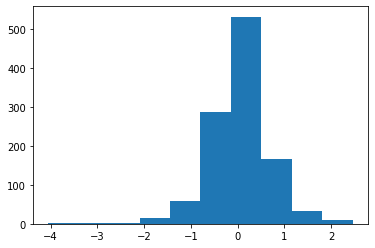

In [17]:
plt.hist(df_stationer.carbon_price)
plt.show()

# Modelling

In [18]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(883, 3)
(220, 3)


## Random forest

In [43]:
rf_model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0)

In [44]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['carbon_price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['carbon_price'].iloc[1:]

In [45]:
X_train

array([[-0.69,  0.  ,  3.41],
       [ 0.29,  0.9 ,  3.42],
       [-0.43,  0.51,  3.42],
       ...,
       [-0.43, -0.08,  1.59],
       [ 1.1 ,  1.39,  1.58],
       [ 0.1 ,  0.45,  1.84]])

In [46]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [47]:
# Predict with the model
rf_y_pred = rf_model.predict(X_test)

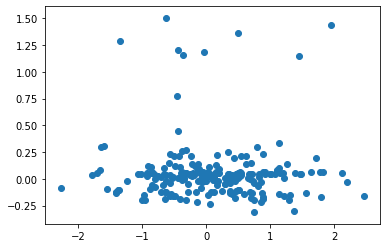

In [48]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

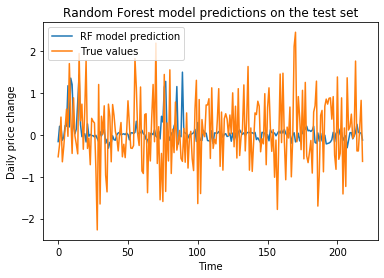

In [49]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(rf_y_pred),label='RF model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('Random Forest model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_rf_with_explanatory_vars.pdf')
plt.show()

In [50]:
mean_squared_error(rf_y_pred,y_test)

0.7599645584375464